# Project 3: Web APIs & NLP

## Contents:
- [Recap](#Recap)
- [Setup](#Setup)
- [Loading Data](#Loading-Data)
- [Basic Text Data Pre-processing](#Basic-Text-Data-Pre-processing)
- [Cleaning Text Data](#Cleaning-Text-Data)
- [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-(EDA))
- [Classification Modelling](#Classification-Modelling)
- [Production Model](#Production-Model)
- [Overall Evaluation](#Overall-Evaluation)

## Recap
In the previous notebook, we have collected posts from two different subreddits — r/GME and r/dogecoin — using Pushshift's API.

## Setup
All libraries used should be added here.

In [1]:
# import libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import emoji # https://pypi.org/project/emoji/
import string
import spacy
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# Note: Microsoft Visual C++ 14.0 or greater is required to install contractions library 
import contractions # https://github.com/kootenpv/contractions

from abbreviations import manual_abbr_dict # available in the abbreviations.py file 
from typos import manual_typos_dict # available in the typos.py file

# download spacy trained pipeline
spacy.cli.download("en_core_web_sm")
# initialize spacy 'en_core_web_sm' model
nlp = spacy.load("en_core_web_sm")

# intialize stopword list
stopword_list = stopwords.words('english')

# this setting widens how many characters pandas will display in a column:
pd.options.display.max_colwidth = 400

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
# path to save the figures
assets_path = '../assets'
os.makedirs(assets_path, exist_ok=True)

# Create a function to save figures
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(assets_path, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Loading Data
Import the datasets required.

In [3]:
# set the input and output relative paths
input_path = '../data'
output_path = '../data'

In [4]:
# write a function to load the datasets
def load_gme_data(filename='GME.csv'):
    csv_gme_path = os.path.join(input_path, filename)
    return pd.read_csv(csv_gme_path)

def load_dogecoin_data(filename='dogecoin.csv'):
    csv_dogecoin_path = os.path.join(input_path, filename)
    return pd.read_csv(csv_dogecoin_path)

In [5]:
GME_df = load_gme_data()
dogecoin_df = load_dogecoin_data()

In [6]:
print('The GME dataset has {} rows and {} columns.'.format(GME_df.shape[0], GME_df.shape[1]))
print('The dogecoin dataset has {} rows and {} columns.'.format(dogecoin_df.shape[0], dogecoin_df.shape[1]))

The GME dataset has 6805 rows and 9 columns.
The dogecoin dataset has 10750 rows and 9 columns.


Combine the datasets.

In [7]:
df = pd.concat([GME_df, dogecoin_df], axis=0).reset_index(drop=True)

In [8]:
# check the first five rows
display(df.head())

,id,full_link,author,created_utc,subreddit,selftext,title,num_comments,score
0,l1n3vd,https://www.reddit.com/r/GME/comments/l1n3vd/greetings_gme_gang/,Jeffamazon,2021-01-21 00:52:21,GME,Just stumbled upon this sub. Didn't know it existed. I joined GME gang back in September and posted some DD to WSB.\n\nHow is this sub organized? If I could recommend a live daily discussion thread and separate megathreads for SEC filings or other market moving news.\n\nCheers!,Greetings GME Gang,55,1
1,l1o60a,https://www.reddit.com/r/GME/comments/l1o60a/help_make_q4_great/,stoney-the-tiger,2021-01-21 01:48:42,GME,[removed],Help Make Q4 Great,0,1
2,l1wi6q,https://www.reddit.com/r/GME/comments/l1wi6q/remember_lads_scared_money_dont_make_money/,B1ake1,2021-01-21 11:13:54,GME,HOLD THE LINES \n\n\n120 shares @27,"Remember lads, scared money don't make money.",0,1
3,l22dsa,https://www.reddit.com/r/GME/comments/l22dsa/how_do_we_know_when_the_squeeze_has_happened/,Dustin_James_Kid,2021-01-21 16:55:19,GME,"I’m new and trying to learn. This stock scares me, because I don’t know how to access info on all the shorts.",How do we know when the squeeze has happened?,8,1
4,l22r5n,https://www.reddit.com/r/GME/comments/l22r5n/where_are_the_fucking_reinforcements/,MailNurse,2021-01-21 17:11:48,GME,Price is sub 40 now. :(.,WHERE ARE THE FUCKING REINFORCEMENTS,20,1


In [9]:
print('The combined dataset has {} rows and {} columns.'.format(df.shape[0], dogecoin_df.shape[1]))

The combined dataset has 17555 rows and 9 columns.


## Basic Text Data Pre-processing
Before jumping to the exploration stage, we need to perform basic data pre-processing steps like null value imputation and removal of unwanted data. 

Let’s see if there are any null values present in our dataset:

In [10]:
df.isnull().sum()

id                 0
full_link          0
author             0
created_utc        0
subreddit          0
selftext        4449
title              0
num_comments       0
score              0
dtype: int64

It appears that the null values present is valid as they are simply posts with title but no text content. We'll impute these null values with empty string.

In [11]:
# impute null values with empty string
df['selftext'] = df['selftext'].fillna('')
df.isnull().sum()

id              0
full_link       0
author          0
created_utc     0
subreddit       0
selftext        0
title           0
num_comments    0
score           0
dtype: int64

When a post on reddit is removed by spam filter or the moderators, the text content will be replaced with '[removed]'. Similarly, when a post on reddit has been deleted by the author who posted it, the text content will be replaced with '[deleted]'. Hence, we want to get rid of the text contents that contains either '[removed]' or '[deleted]'.

In [12]:
# remove text contents that contains either '[removed]' or '[deleted]'
df = df[(df['selftext']!='[deleted]') & (df['selftext']!='[removed]')]

In [13]:
print('The combined dataset has {} rows and {} columns now.'.format(df.shape[0], dogecoin_df.shape[1]))

The combined dataset has 14318 rows and 9 columns now.


## Cleaning Text Data
Generally, text data contains a lot of noise either in the form of symbols or in the form of punctuations and stopwords. Therefore, it is essential that we clean the text, not just for making it more understandable but also for getting better insights. Based on our problem statement, we'll only be cleaning the text in the two columns: `title` & `selftext`.

So, let’s start with the `title` column first. Let's take a look at the text present in this column:

In [14]:
df['title'].unique()

array(['Greetings GME Gang',
       "Remember lads, scared money don't make money.",
       'How do we know when the squeeze has happened?', ...,
       "Don't be a fool!",
       'this elon musk boring company not a flamethrower is syckkkkk',
       'Dogecoin will hit $11 on June 11th 2022.'], dtype=object)

We can see that we have some contractions like “Don't”, numbers like “11”, slangs like 'syckkkk' and punctuations like “,”, “!” and “.” present in the title. 

In [15]:
for index,text in enumerate(df['selftext'][36:40]):
  print('Text Content %d:\n'%(index+1),text, '\n\n---')

Text Content 1:
 Just what it says. 

---
Text Content 2:
 Make sure to download the GameStop add and give it 5 star rating. And if you have any left of money (that didn’t go into GME shares) make sure to sign up for their rewards program. Cheers. $GME 🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀 

---
Text Content 3:
 Was there a specific catalyst? 

---
Text Content 4:
 One of Andrew Left's cases for selling $GME was the fact that shorts can still borrow shares easily and aren't paying high interest rates to hold these shares! This is **blasphemy**. On E-Trade right now its literally **impossible** to short the stock (no shares available, check picture). E-Trade is one of the largest trading platforms in the world!

&amp;#x200B;

https://preview.redd.it/zrtz5c8e0uc61.jpg?width=1080&amp;format=pjpg&amp;auto=webp&amp;s=784fbbb3de426dc7f2cad36c7730e0150d871c4e

And when you were able to short the stock the borrow rates were **astronomical**..... not "average" as he suggests.... I have posted proof of that a

Similarly, we can see that we have contractions, numbers, punctuations, characters like '\&amp;#x200B;' that stem from (Reddit-specific) markdown formatting, html links, abbreviations like 'MTD' and emojis like '🚀' present in the `selftext` column. 

We’ll build a text cleaning function by chaining the following operations:
- Clean characters that stem from (Reddit-specific) markdown formatting
- Convert emoji to text using *emoji* library
- Remove HTML tags and links
- Convert all text to lowercase
- Convert slangs/typos to its original word
- Expand abbreviations
- Expand contractions using *contractions* library (Note: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/)
- Remove special characters (we'll keep the hypenated words together)
- Remove extra whitespace

We'll keep the following steps optional:
- Stopwords removal
- Stemming
- Lemmatization 

**Clean characters from (Reddit-specific) markdown formatting**

In [16]:
# create a function to clean characters from (Reddit-specific) markdown formatting
def clean_reddit_formating(text):
    """
    Clean characters from (Reddit-specific) markdown formatting.
    """
    # remove new line
    text = " ".join([word for word in text.split('\n') if word.strip() != ''])
    # remove &amp;#x200B; (bullet point) 
    text = re.sub('&amp;#x200B;', '', text)
    # remove &gt; (quote)
    text = re.sub('&gt;', '', text)
    return text

sample_text = 'I also believe this is false. \n\n &amp;#x200B;'

print('[input]:', sample_text)
print('[output]:',clean_reddit_formating(sample_text))

[input]: I also believe this is false. 

 &amp;#x200B;
[output]: I also believe this is false.   


**Convert emoji to text**

In [17]:
sample_text = 'Cheers. $GME 😀🚀🚀🚀🚀'
print('[input]:', sample_text)
print('[output]:', emoji.demojize(sample_text))

[input]: Cheers. $GME 😀🚀🚀🚀🚀
[output]: Cheers. $GME :grinning_face::rocket::rocket::rocket::rocket:


**Remove html tags and links**

In [18]:
# create a function to remove html tags and links since they are not useful for our nlp tasks
def strip_html_tags_and_links(text):
    """
    Remove html tags and links from text.
    """
    # remove html tags using BeautifulSoupw
    text = BeautifulSoup(text).get_text()
    # remove html links
    regex_html = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    text = re.sub(regex_html, r'', text, flags=re.MULTILINE)
    return text

sample_text = '<html><h2>some important text</h2></html> https://preview.redd.it/'
print('[input]:', sample_text)
print('[output]:', strip_html_tags_and_links(sample_text))

[input]: <html><h2>some important text</h2></html> https://preview.redd.it/
[output]: some important text 


**Convert slangs/typos to its original word**

We will leverage the set of typos available in the [typos.py](./typos.py) file.

In [19]:
# create a function to convert slangs/typos to its original word
def recover_original_word(text, typos_dict=manual_typos_dict):
    """
    Convert slangs or typos to its original word.
    """
    # regular expression for finding abbreviations
    # put \b (boundary) to avoid the characters in the word to be replaced
    typos_re=re.compile('(%s)' % '|'.join(r'\b%s\b' % s for s in typos_dict.keys()))
    
    def replace(match):
        matched_str = re.escape(match.group(0))
        return typos_dict[matched_str]
    
    text = typos_re.sub(replace, text)
    return text

sample_text = 'should i buy $500 worth of dodgecoin?'
print('[input]:', sample_text)
print('[output]:', recover_original_word(sample_text))
## note at how dogecoin was misspelled

[input]: should i buy $500 worth of dodgecoin?
[output]: should i buy $500 worth of dogecoin?


**Expand abbreviations**

We will leverage the set of abbreviations available in the [abbreviations.py](./abbreviations.py) file.

In [20]:
# create a function for expanding abbreviations
def expand_abbr(text, abbr_dict=manual_abbr_dict):
    """
    Expand abbreviations in text.
    """
    # regular expression for finding abbreviations
    # put \b (boundary) to avoid the characters in the word to be replaced
    abbr_re=re.compile('(%s)' % '|'.join(r'\b%s\b' % s for s in abbr_dict.keys()))
    
    def replace(match):
        matched_str = re.escape(match.group(0))
        return abbr_dict[matched_str]
    
    text = abbr_re.sub(replace, text)
    return text

sample_text = 'help this doge noob pls!'
print('[input]:', sample_text)
print('[output]:', expand_abbr(sample_text))
## note at how pls has been expanded to please

[input]: help this doge noob pls!
[output]: help this doge noob please!


**Expand contractions**

In [21]:
sample_text = "let's goooooo!"
print('[input]:', sample_text)
print('[output]:', contractions.fix(sample_text))

[input]: let's goooooo!
[output]: let us goooooo!


**Remove special characters**

In [22]:
# create a function to remove special characters
# we'll enable a parameter to toggle on or off the step to remove numbers

def remove_special_characters(text, remove_digits=False):
    """
    Remove special characters from text. Removing digits have been set as optional.
    """
    # keep hyphenated words together
    table = str.maketrans('', '', '-')
    text = ' '.join([word.translate(table) for word in text.split()])
    # removing punctuations in string
    text = re.sub(r'[^\w\s]', ' ', text)
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

sample_text = 'should have bought more at 0.65 ^-^ :grinning_face::rocket::rocket: e-trade'

print('[input]:', sample_text)
print('[output without digits removed]: ',remove_special_characters(sample_text , remove_digits=False))
print('[output with digits removed]: ',remove_special_characters(sample_text , remove_digits=True))

[input]: should have bought more at 0.65 ^-^ :grinning_face::rocket::rocket: e-trade
[output without digits removed]:  should have bought more at 0 65     grinning_face  rocket  rocket  etrade
[output with digits removed]:  should have bought more at       grinning_face  rocket  rocket  etrade


**Remove extra whitespaces**

In [23]:
# create a function to remove extra whitespaces
def remove_extra_whitespaces(text):
    """
    Remove extra whitespaces from text.
    """
    text = re.sub(' +', ' ', text)
    text = ' '.join([word.strip() for word in text.split()])
    return text

sample_text = "Just  what    it says."
print('[input]:', sample_text)
print('[output]:', remove_extra_whitespaces(sample_text))

[input]: Just  what    it says.
[output]: Just what it says.


**Stopwords removal**

In [24]:
# create a function to remove stopwords
def remove_stopwords(text, stopword_list):
    """
    Remove stopwords from text.
    """
    tokens = nltk.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_text = ' '.join([token for token in tokens if token not in stopword_list])  
    return filtered_text

sample_text = 'why does everyone keep saying there is a good chance there is going to be a big price drop this weekend ? '
print('[input]:', sample_text)
print('[output]:', remove_stopwords(sample_text, stopword_list))

[input]: why does everyone keep saying there is a good chance there is going to be a big price drop this weekend ? 
[output]: everyone keep saying good chance going big price drop weekend ?



**Stemming**

In [25]:
# create a function for stemming
def stem_text(text):
    """
    Standardise words to their base or root stem.
    """
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

sample_text = 'why does everyone keep saying there is a good chance there is going to be a big price drop this weekend ? '
print('[input]:', sample_text)
print('[output]:', stem_text(sample_text))

[input]: why does everyone keep saying there is a good chance there is going to be a big price drop this weekend ? 
[output]: whi doe everyon keep say there is a good chanc there is go to be a big price drop thi weekend ?


**Lemmatization**

In [26]:
# create a function for lemmatization
def lemmatize_text(text):
    """
    Standardise words to their base or root word.
    """
    text = nlp(text)
    text = ' '.join([word.lemma_ for word in text])
    return text.lower()

sample_text = 'why does everyone keep saying there is a good chance there is going to be a big price drop this weekend ? '
print('[input]:', sample_text)
print('[output]:', lemmatize_text(sample_text))

[input]: why does everyone keep saying there is a good chance there is going to be a big price drop this weekend ? 
[output]: why do everyone keep say there be a good chance there be go to be a big price drop this weekend ?



Bringing it all together — building a text cleaning function:

In [27]:
def clean_text(text, demoji = True, abbreviation_expansion = True, remove_digits = True, 
               stopword_removal = False, stopword_list= stopword_list, text_stemming = False, text_lemmatization = False):
    """
    A single wrapper function to clean text data. 
    Removing stop words, stemming and lemmatising have been set as optional.
    """

    # clean characters that stem from (Reddit-specific) markdown formatting 
    text = clean_reddit_formating(text)
    
    if demoji == True:
        # convert emoji to text 
        text = emoji.demojize(text)
    
    # remove html tags and links
    text = strip_html_tags_and_links(text)
    
    # convert text to lower case
    text = text.lower()

    # convert slangs/typos to its original word
    text = recover_original_word(text)
    
    if abbreviation_expansion == True:
        # expand abbreviations
        text = expand_abbr(text)

    # expand contractions
    text = contractions.fix(text).lower()
    
    # remove special characters    
    text = remove_special_characters(text, remove_digits=remove_digits)
    
    # tokenise and strip whitespaces
    text = remove_extra_whitespaces(text)
    
    # stopwords removal
    if stopword_removal == True:
        text = remove_stopwords(text, stopword_list)
    
    # stemming text
    if text_stemming == True:
        text = stem_text(text)
        
    # lemmatize text
    if text_lemmatization == True:
        text = lemmatize_text(text)
        
    return text

Let’s now put the text cleaning function into action. We will first combine the `title` & `selftext` together to form a document for each post. Then, we will clean the combined text using the function we have created.

In [28]:
# combining title and text content
df['full_text'] = df["title"].map(str)+ ' ' + df["selftext"]

In [29]:
# clean full_text without lemmatising/stemming and without removing stopwords
df['cleaned_full_text'] = df['full_text'].apply(lambda x: clean_text(x))

In [30]:
# show a sample output
df.iloc[2][['full_text', 'cleaned_full_text']].to_dict()

{'full_text': 'How do we know when the squeeze has happened? I’m new and trying to learn. This stock scares me, because I don’t know how to access info on all the shorts.',
 'cleaned_full_text': 'how do we know when the squeeze has happened i am new and trying to learn this stock scares me because i do not know how to access information on all the shorts'}

In [31]:
# export to csv
df.to_csv(output_path + '/combined_dataset.csv')

## Exploratory Data Analysis (EDA)

Here is the data dictionary of the columns:

|      Feature      |   Type  |                       Description                       |
|:-----------------|:-------:|:-------------------------------------------------------|
| id                | object  | Unique ID for each reddit submission                    |
| full_link         | object  | URL of the submission                                   |
| author            | object  | The username of the author who published the submission |
| created_utc       | object  | The timestamp when the submission was created           |
| subreddit         | object  | Name of the subreddit                                   |
| selftext          | object  | The content of the submission                           |
| title             | object  | The title of the submission                             |
| num_comments      | integer | Number of comments by readers                           |
| score             | integer | Number of upvotes minus the number of downvotes         |
| full_text         | object  | The title and content of the submission                 |
| cleaned_full_text | object  | Cleaned title and content of the submission             |

### EDA on title and text content combined

Let's look at the word counts of each reddit post. To get an accurate estimate of the word counts of each reddit post, we'll create a new column called `cleaned_full_text_word_count` that contains the number of words in `cleaned_full_text` column for each post:

In [32]:
# creating a word count column
df['cleaned_full_text_word_count'] = [len(word.split()) for word in df['cleaned_full_text']]

### Longest and shortest title and text content combined
Let's look at the five longest and five shortest `cleaned_full_text` based off of `cleaned_full_text_word_count`:

In [33]:
# show the five longest full_text
df.sort_values(by = 'cleaned_full_text_word_count', ascending=False).head()

,id,full_link,author,created_utc,subreddit,selftext,title,num_comments,score,full_text,cleaned_full_text,cleaned_full_text_word_count
25,l2h6vm,https://www.reddit.com/r/GME/comments/l2h6vm/text_of_conspiracy_post_before_wsb_privated/,Pepe_Le_BUYMSFTCALLS,2021-01-22 05:42:33,GME,"\n\n**GME - The Truth Behind Cramer, The News, Melvin &amp; Shitron (Evidence of my warnings)**\n\nOC[Discussion](https://www.reddit.com/r/wallstreetbets/search?q=flair_name%3A%22Discussion%22&amp;restrict_sr=1)\n\n**TLDR: The whole Citron attack, the news articles, Cramer etc was planned by pissed off hedge-funds (mainly Melvin) who want WSB to appear to be a single, coordinated market manip...",Text of Conspiracy post before WSB privated,15,1,"Text of Conspiracy post before WSB privated \n\n**GME - The Truth Behind Cramer, The News, Melvin &amp; Shitron (Evidence of my warnings)**\n\nOC[Discussion](https://www.reddit.com/r/wallstreetbets/search?q=flair_name%3A%22Discussion%22&amp;restrict_sr=1)\n\n**TLDR: The whole Citron attack, the news articles, Cramer etc was planned by pissed off hedge-funds (mainly Melvin) who want WSB to app...",text of conspiracy post before wallstreetbets privated gamestop the truth behind cramer the news melvin shitron evidence of my warnings oc discussion too long did not read the whole citron attack the news articles cramer etc was planned by pissed off hedgefunds mainly melvin who want wallstreetbets to appear to be a single coordinated market manipulating entity source london hedge fund pm hi e...,2117
1058,l6ed29,https://www.reddit.com/r/GME/comments/l6ed29/found_this_online_its_amazing_gme_hold_hooooold/,sophisticatedaddy,2021-01-27 21:04:16,GME,"I Present To You: The GME Gamma Short Feedback Squeeze\n\nUnfortunately WSB mods already took this down twice, so here I am.\n\nWhat an exciting time to be alive! We're gonna bust an institutional short hedge fund Robinhood-style in the middle of a global pandemic and trigger a great redistribution of wealth.\n\nTLDR: Short squeeze trigger might've changed from waiting for GME/RC news about po...","Found this online, it’s amazing! GME 🚀 HOLD HOOOOOLD",4,12,"Found this online, it’s amazing! GME 🚀 HOLD HOOOOOLD I Present To You: The GME Gamma Short Feedback Squeeze\n\nUnfortunately WSB mods already took this down twice, so here I am.\n\nWhat an exciting time to be alive! We're gonna bust an institutional short hedge fund Robinhood-style in the middle of a global pandemic and trigger a great redistribution of wealth.\n\nTLDR: Short squeeze trigger m...",found this online it is amazing gamestop rocket hold hold i present to you the gamestop gamma short feedback squeeze unfortunately wallstreetbets mods already took this down twice so here i am what an exciting time to be alive we are going to bust an institutional short hedge fund robinhoodstyle in the middle of a global pandemic and trigger a great redistribution of wealth too long did not re...,1783
3819,l7ye0f,https://www.reddit.com/r/GME/comments/l7ye0f/no_robinhood_webull_and_other_brokers_who_limited/,InvincibearREAL,2021-01-29 17:26:25,GME,"I know this is an unpopular opinion because the optics make it appear that the brokers all out to protect the shorts and stick the bill on the little guys, classic David vs Goliath. So what actually is happening?\n\n**TLDR**; The DTC raised collateral limits to settle certain stock transactions from 1-3% to 100% for the 2 days held in escrow, which trickled down to clearing houses which don’t ...","No, Robinhood, Webull, and other brokers who limited buying yesterday are not colluding. This is the real reason behind brokers restricting buying $GME, $AMC, etc.",3,1,"No, Robinhood, Webull, and other brokers who limited buying yesterday are not colluding. This is the real reason behind brokers restricting buying $GME, $AMC, etc. I know this is an unpopular opinion because the optics make it appear that the brokers all out to protect the shorts and stick the bill on the little guys, classic

In [34]:
print('The longest word count is {}.'.format(df['cleaned_full_text_word_count'].max()))

The longest word count is 2117.


In [35]:
# show the five shortest full_text
df.sort_values(by = 'cleaned_full_text_word_count', ascending=True).head()

,id,full_link,author,created_utc,subreddit,selftext,title,num_comments,score,full_text,cleaned_full_text,cleaned_full_text_word_count
7771,n55nmx,https://www.reddit.com/r/dogecoin/comments/n55nmx/122/,Derby_The_Bear,2021-05-05 02:59:53,dogecoin,,$1.22,0,1,$1.22,,0
2093,l6zv9f,https://www.reddit.com/r/GME/comments/l6zv9f/游戏驿站加油中国人参与战斗我们并肩作战/,Aware_Shape_6361,2021-01-28 15:34:25,GME,,游戏驿站加油，中国人参与战斗，我们并肩作战,0,1,游戏驿站加油，中国人参与战斗，我们并肩作战,,0
9806,n5896l,https://www.reddit.com/r/dogecoin/comments/n5896l/1/,Academic_IT,2021-05-05 05:26:57,dogecoin,,1$,2,1,1$,,0
663,l67e1t,https://www.reddit.com/r/GME/comments/l67e1t/350/,Thewasheast,2021-01-27 15:53:59,GME,,350!!!!!!!!!,8,1,350!!!!!!!!!,,0
10023,n58nex,https://www.reddit.com/r/dogecoin/comments/n58nex/69/,Jrodmxt,2021-05-05 05:51:43,dogecoin,,69!!!!,1,1,69!!!!,,0


In [36]:
print('The shortest word count is {}.'.format(df['cleaned_full_text_word_count'].min()))

The shortest word count is 0.


The shortest word count is 0, while the longest word count is 2117. It is strange that the shortest word count is 0 so let's investigate on this. Upon further investigation, we can see that in the original title and content of these posts, there were non-english words. Also some of these posts only contained links and numbers in its title. Hence, after cleaning our text, there are 0 word counts available in these posts. 

Therefore, we want to remove all posts that are shorter than 5 words, as it would be difficult to determine any information from the text. We want to focus on accurately predicting posts with contents.

In [37]:
df = df[df['cleaned_full_text_word_count'] >= 5]

In [38]:
print('The dataset has {} rows and {} columns.'.format(df.shape[0], dogecoin_df.shape[1]))

The dataset has 13315 rows and 9 columns.


### Visualise the distribution of word counts
Let's plot the distribution of word counts of each reddit post based off of `cleaned_full_text_word_count`:

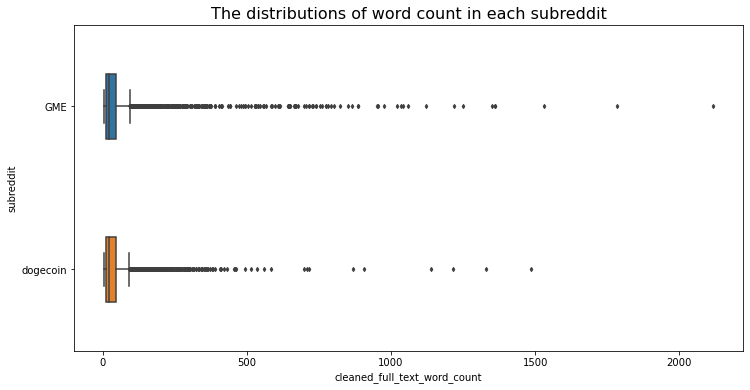

In [39]:
#set figure size
plt.figure(figsize=(12,6))
#plot boxplot
word_count = sns.boxplot(data= df, y= 'subreddit', x= 'cleaned_full_text_word_count',orient='h',width=0.4,fliersize=3);

#Set title and labels 
word_count.set_yticklabels(['GME', 'dogecoin']);
word_count.set_title("The distributions of word count in each subreddit",fontsize=16);

In [40]:
# looking at the word count statistics
df.groupby('subreddit')['cleaned_full_text_word_count'].describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
GME,5684.0,48.862949,103.693810,5.0,12.0,23.0,45.0,2117.0
dogecoin,7631.0,38.742629,58.240722,5.0,12.0,22.0,44.0,1484.0


Looking at the word count statistics, the 2 subreddits are almost similar in post length. On average, there are 48.86 words per post on GME as compared to 38.74 words per post on dogecoin.

In [41]:
# checking for wordcount more than 1,700
df[df['cleaned_full_text_word_count']>1700]

,id,full_link,author,created_utc,subreddit,selftext,title,num_comments,score,full_text,cleaned_full_text,cleaned_full_text_word_count
25,l2h6vm,https://www.reddit.com/r/GME/comments/l2h6vm/text_of_conspiracy_post_before_wsb_privated/,Pepe_Le_BUYMSFTCALLS,2021-01-22 05:42:33,GME,"\n\n**GME - The Truth Behind Cramer, The News, Melvin &amp; Shitron (Evidence of my warnings)**\n\nOC[Discussion](https://www.reddit.com/r/wallstreetbets/search?q=flair_name%3A%22Discussion%22&amp;restrict_sr=1)\n\n**TLDR: The whole Citron attack, the news articles, Cramer etc was planned by pissed off hedge-funds (mainly Melvin) who want WSB to appear to be a single, coordinated market manip...",Text of Conspiracy post before WSB privated,15,1,"Text of Conspiracy post before WSB privated \n\n**GME - The Truth Behind Cramer, The News, Melvin &amp; Shitron (Evidence of my warnings)**\n\nOC[Discussion](https://www.reddit.com/r/wallstreetbets/search?q=flair_name%3A%22Discussion%22&amp;restrict_sr=1)\n\n**TLDR: The whole Citron attack, the news articles, Cramer etc was planned by pissed off hedge-funds (mainly Melvin) who want WSB to app...",text of conspiracy post before wallstreetbets privated gamestop the truth behind cramer the news melvin shitron evidence of my warnings oc discussion too long did not read the whole citron attack the news articles cramer etc was planned by pissed off hedgefunds mainly melvin who want wallstreetbets to appear to be a single coordinated market manipulating entity source london hedge fund pm hi e...,2117
1058,l6ed29,https://www.reddit.com/r/GME/comments/l6ed29/found_this_online_its_amazing_gme_hold_hooooold/,sophisticatedaddy,2021-01-27 21:04:16,GME,"I Present To You: The GME Gamma Short Feedback Squeeze\n\nUnfortunately WSB mods already took this down twice, so here I am.\n\nWhat an exciting time to be alive! We're gonna bust an institutional short hedge fund Robinhood-style in the middle of a global pandemic and trigger a great redistribution of wealth.\n\nTLDR: Short squeeze trigger might've changed from waiting for GME/RC news about po...","Found this online, it’s amazing! GME 🚀 HOLD HOOOOOLD",4,12,"Found this online, it’s amazing! GME 🚀 HOLD HOOOOOLD I Present To You: The GME Gamma Short Feedback Squeeze\n\nUnfortunately WSB mods already took this down twice, so here I am.\n\nWhat an exciting time to be alive! We're gonna bust an institutional short hedge fund Robinhood-style in the middle of a global pandemic and trigger a great redistribution of wealth.\n\nTLDR: Short squeeze trigger m...",found this online it is amazing gamestop rocket hold hold i present to you the gamestop gamma short feedback squeeze unfortunately wallstreetbets mods already took this down twice so here i am what an exciting time to be alive we are going to bust an institutional short hedge fund robinhoodstyle in the middle of a global pandemic and trigger a great redistribution of wealth too long did not re...,1783


The GME subreddit have 2 outlier posts with more than 1,700 words. We will retain them since these are legitimate posts and there is no other compelling reason to remove them.

### Visualising unigram and bigram
Let's visualise the n-grams to understand what are the frequently occurring words and its distribution in each subreddit. An N-gram is a sequence of N tokens (or words). Eg. A 1-gram (or unigram) is a one-word sequence and a 2-gram (or bigram) is a two-word sequence of words.

To visualise the n-grams, we will make use of the bag-of-words approach. A bag of words is a representation of text that describes the occurrence of words within a document. We just keep track of word counts and disregard the grammatical details and the word order. It is called a “bag” of words because any information about the order or structure of words in the document is discarded. The model is only concerned with whether known words occur in the document, not where in the document. We'll use the CountVectorizer() function from the scikit-learn library to implement the BoW model.  We'll also be excluding stopwords from our results.

**Unigram**

In [42]:
gme = df[df['subreddit'] == 'GME']
dogecoin = df[df['subreddit'] == 'dogecoin']

In [43]:
# visualizing unigrams
def get_top_n_unigram(corpus, n=None):
    """
    List the top n unigram according to its occurrence in a text corpus.
    """
    stopwords = stopword_list
    vec = CountVectorizer(stop_words = stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [44]:
# get the top 20 unigram
gme_top20_unigram = dict(get_top_n_unigram([word for word in gme['cleaned_full_text']],20))
dogecoin_top20_unigram = dict(get_top_n_unigram([word for word in dogecoin['cleaned_full_text']],20))

In [45]:
# create a function to visualise the top n-grams
def visualise_top_n_grams(dict1, dict2, wspace):
    fig, axes = plt.subplots(1,2, figsize=(15,9));
    
    # plot the first graph
    plt.subplot(1,2,1)
    gme_text = plt.barh(range(len(dict1)), dict1.values(),align = 'center',color='xkcd:lightblue');
    
    # label axes 
    plt.yticks(range(len(dict1)),dict1.keys(),fontsize=12);
    plt.title('Top 20 words in GME subreddit')
    plt.xlabel('Frequency')
    plt.gca().invert_yaxis()
    
    # plot the second graph
    plt.subplot(1,2,2)
    dogecoin_text = plt.barh(range(len(dict2)), dict2.values(),align = 'center',color='xkcd:light orange');
    
    # label axes 
    plt.yticks(range(len(dict2)),dict2.keys(),fontsize=12);
    plt.title('Top 20 words in dogecoin subreddit')
    plt.xlabel('Frequency')
    plt.gca().invert_yaxis()
    
    plt.subplots_adjust(wspace= wspace)
    plt.show()

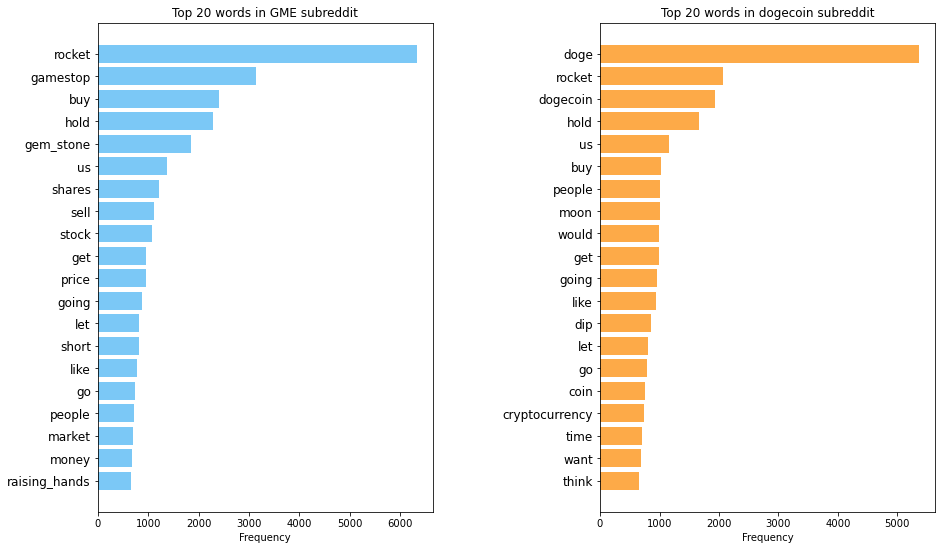

In [46]:
visualise_top_n_grams(gme_top20_unigram, dogecoin_top20_unigram, 0.5)

In the GME subreddit, 'gamestop', 'buy', 'hold' are the most occurring words, while 'rocket' and 'gem_stone' are the most occurring emojis. In the dogecoin reddit, 'doge', 'dogecoin', 'hold' are the most occurring words, while 'rocket' is the most occurring emoji.

Based on the most occurrring word/emoji used, we can see that there is a new type of lingo being used by the stock market *[(source)](https://www.cnet.com/personal-finance/investing/gamestop-stock-surge-lingo-heres-what-reddits-wallstreetbets-vocabulary-means/)*. The "rocket" emoji blasting off which signals bullish or upward moving stock. The word "hold" to signify holding on to the stock, even if it goes down in value. The "gemstone"/"diamond" emoji refers to risk takers who are prepared to hold onto their stocks or securities for a long time. The "gemstone"/"diamond" emoji is often used with a hand emoji to signify diamond hands.*[(source)](https://stayhipp.com/glossary/what-does-%F0%9F%92%8E%F0%9F%A4%B2-diamond-hands-mean/)*

In [47]:
# check for common words in both subreddits
common_words = set(gme_top20_unigram).intersection(set(dogecoin_top20_unigram))
print(common_words)

{'rocket', 'like', 'people', 'go', 'us', 'get', 'let', 'hold', 'buy', 'going'}


We can see that there common words/emojis that are frequent to both subreddits, such as 'buy', 'people', 'us', 'rocket', 'let', 'hold', 'going', 'like', 'go', 'get'. This is expected given that both subreddits are similar in topic.

**Bigram**

In [48]:
# visualizing bigrams
def get_top_n_bigram(corpus, n=None):
    """
    List the top n bigram according to its occurrence in a text corpus.
    """
    stopwords = stopword_list
    vec = CountVectorizer(ngram_range=(2, 2), stop_words = stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [49]:
# get the top 20 bigram
gme_top20_bigram = dict(get_top_n_bigram([word for word in gme['cleaned_full_text']],20))
dogecoin_top20_bigram = dict(get_top_n_bigram([word for word in dogecoin['cleaned_full_text']],20))

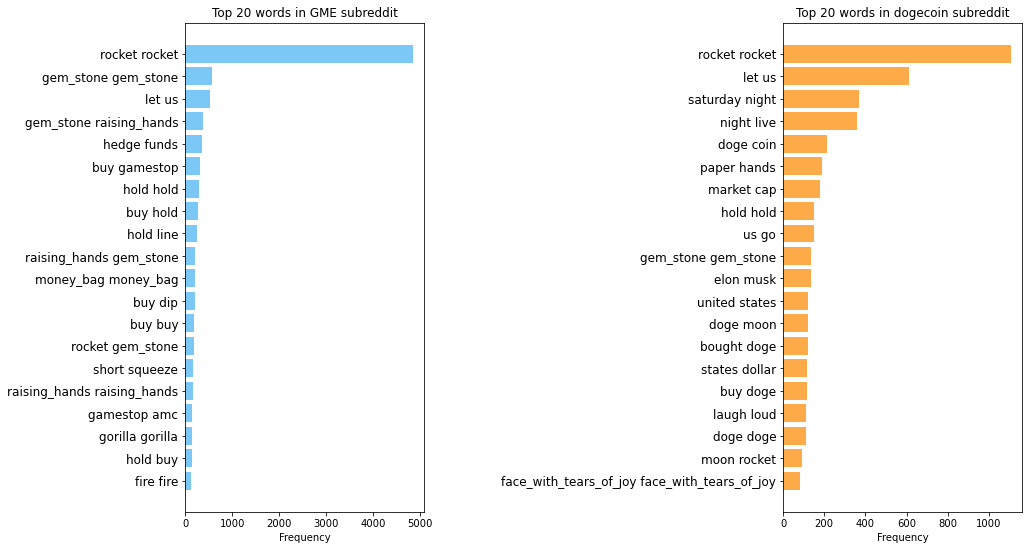

In [50]:
visualise_top_n_grams(gme_top20_bigram, dogecoin_top20_bigram, 1.5)

The bigrams used within the GME subreddit suggest that the community tends to add emojis to their posts. We can also see keywords related to "hedge funds", "short squeeze" and "AMC". After reading up on some of the posts containing these keywords and researching, we found that the GameStop mania was a result of the tug-of-war battle between Reddit traders and hedge funds (think David vs. Goliath story) *[(source)](https://www.forbes.com/sites/naeemaslam/2021/01/27/gamestop-stock-in-battle-between-hedge-funds-and-reddit-day-traders-melvin-capital-closes-its-short/?sh=15f6cc7c2471)*. Members of the Reddit community targeted GameStop's stock after they noticed that hedge funds were short-selling it. The community of Reddit traders encouraged each other to buy and accumulate GameStop’s shares, driving a meteoric rise in GameStop’s stock price. This process is called a short squeeze. Besides GameStop, Reddit traders also have their attention to other stocks like AMC.

For the dogecoin subreddit, we can see keywords related to "saturday night live" and "elon musk". After reading up on some of the posts containing these keywords and researching, we found that Reddit users were mostly excited for Elon Musk's Saturday Night Live (a NBCUniversal comedy show) appearance on Saturday (May 8). This is mainly due to Elon Musk being a supporter of dogecoin *[(source)](https://www.business-standard.com/article/international/elon-musk-to-send-cryptocurrency-funded-satellite-doge-1-to-moon-121051000289_1.html)* and many Reddit traders do not want to miss out on any buzz that could possibly stem from Elon Musk’s hosting of Saturday Night Live.

Overall, it is clear that there are common words/emojis which are frequent to both subreddits, such as 'buy', 'people', 'us', 'rocket', 'let', 'hold', 'going', 'like', 'go', 'get'. Given their high frequency in both datasets, these words may not be useful for the classification models to distinguish between the 2 subreddits. Hence, we would add them to stopword list as they are common occurences in both subreddits.

It appears that we will be able to answer our problem statement afterall. There will be a clearer distinction of the words usage in each subreddit after removing words with common occurences in both subreddits. We will evaluate it again below.

### The target variable: Subreddit Name
Finally, let's check for any class imbalance:

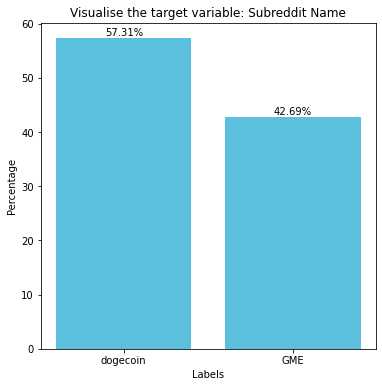

In [51]:
# visualize the target variable
fig = plt.figure(figsize=(6,6))
x = np.arange(len(df['subreddit'].value_counts(normalize='True').index))
y = list(df['subreddit'].value_counts(normalize='True').values * 100)

x_name = list(df['subreddit'].value_counts(normalize='True').index)
plt.xticks(x, x_name)

# add title and axis names
plt.title('Visualise the target variable: Subreddit Name')
plt.xlabel('Labels')
plt.ylabel('Percentage')
 
plt.bar(x, y, color= '#5bc0de')

# plot labels on graph
for a,b in zip(x, y): 
    plt.text(a, b+0.5, str(round(b,2)) + '%', ha="center")

plt.show()

The proportion of our target variables are considered to be somewhat balanced.

## Classification Modelling

### Model Preparation

In [52]:
# additional stopwords added
stopword_list =  stopword_list + ['buy', 'people', 'us', 'rocket', 'let', 'hold', 'going', 'like', 'go', 'get']

Lemmatisation has been chosen as the preferred way of reducing words to a common base since it considers the context and converts them to its meaningful base form.

In [53]:
# remove additional stopwords and apply lemmatising
df['cleaned_full_text'] = df['full_text'].apply(lambda x: clean_text(x, stopword_removal = True, stopword_list= stopword_list, text_lemmatization = True))

In [54]:
# show a sample output
df.iloc[2][['full_text', 'cleaned_full_text']].to_dict()

{'full_text': 'How do we know when the squeeze has happened? I’m new and trying to learn. This stock scares me, because I don’t know how to access info on all the shorts.',
 'cleaned_full_text': 'know squeeze happen new trying learn stock scare know access information short'}

In [55]:
df.drop(columns = 'cleaned_full_text_word_count', inplace=True)

Create predictor and target variables.

In [56]:
# creating the target variable for classification modelling (0 for r/GME & 1 for r/dogecoin).
df['target'] = np.where(df['subreddit'] == 'dogecoin', 1, 0)

In [57]:
# define the feature and target variable
X = df['cleaned_full_text']
y = df['target']

Train, test, split.

In [58]:
# train/test split of 80/20
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42,
                                                    stratify= y)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(10652,) (2663,) (10652,) (2663,)


### Model Baseline
In order to evaluate whether the predictions generated from our algorithm are good or not, we will need to establish a baseline model. A baseline provides a point of comparison for the more advanced methods that we will evaluate later. Here, we will set our baseline as the class (r/dogecoin) that has the most observations.

In [59]:
# set  𝑦̂
y_pred = 1
y_train_baseline = np.array([y_pred] * y_train.shape[0])
y_test_baseline = np.array([y_pred] * y_test.shape[0])

In [60]:
# evaulation metrics: accuracy, f1 score
print("---Training Set---")
print('Baseline Train Accuracy Score:', accuracy_score(y_train, y_train_baseline))
print('Baseline Train F1-Score:', f1_score(y_train, y_train_baseline))
print('\n')
print("---Test Set---")
print('Baseline Test Accuracy Score:', accuracy_score(y_test, y_test_baseline))
print('Baseline Test F1-Score:', f1_score(y_test, y_test_baseline))

---Training Set---
Baseline Train Accuracy Score: 0.5731318062335712
Baseline Train F1-Score: 0.7286507131348094


---Test Set---
Baseline Test Accuracy Score: 0.573037927149831
Baseline Test F1-Score: 0.7285748388636907


### Model Training
We will consider using two different NLP vectorizers - Count Vectorizer & TF-IDF Vectorizer. We will build a pipeline to select the best vectorizers by iterating over classification models - Logistic Regression, Naive Bayes & Random Forest Classifier - to select the best parameters which produce the best model performance.

**Logistics Regression: CVEC vs TDIF vectorizers**

In [61]:
# pipeline & gridsearch setup
lr_pipe = Pipeline([("vec",  None),
                       ('lr',LogisticRegression(random_state=42, max_iter=5_000))])

# establish hyperparameters for gridsearch
lr_param_grid = [{'vec': [CountVectorizer(), TfidfVectorizer()],
                  'vec__max_features': [None, 1000, 2000],
                  'vec__min_df':[1, 2],
                  'vec__max_df':[0.9, 1.0],
                  'vec__ngram_range': [(1,1), (1,2)],
                  # trying different alphas of: 10, 1, 0.1 (C = 1/alpha)
                  'lr__C': [0.1,1,10]}]

# gridsearch of parameters, using 5 fold cross validation 
# search across different combinations and use all available cpu cores
lr_gs = GridSearchCV(lr_pipe, 
                     lr_param_grid,
                     cv=5, 
                     verbose =1, 
                     n_jobs = -1, 
                     scoring = 'f1')

# fit the model
%time lr_gs.fit(X_train,y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  2.4min finished


Wall time: 2min 23s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vec', None),
                                       ('lr',
                                        LogisticRegression(max_iter=5000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid=[{'lr__C': [0.1, 1, 10],
                          'vec': [CountVectorizer(),
                                  TfidfVectorizer(max_df=0.9,
                                                  ngram_range=(1, 2))],
                          'vec__max_df': [0.9, 1.0],
                          'vec__max_features': [None, 1000, 2000],
                          'vec__min_df': [1, 2],
                          'vec__ngram_range': [(1, 1), (1, 2)]}],
             scoring='f1', verbose=1)

In [62]:
print("Best parameters from gridsearch: {}".format(lr_gs.best_params_))
print('\n')
print("5-fold CV F1-score for Logistic Regression: %0.3f" % lr_gs.best_score_)

Best parameters from gridsearch: {'lr__C': 10, 'vec': TfidfVectorizer(max_df=0.9, ngram_range=(1, 2)), 'vec__max_df': 0.9, 'vec__max_features': None, 'vec__min_df': 1, 'vec__ngram_range': (1, 2)}


5-fold CV F1-score for Logistic Regression: 0.912


In [63]:
# generate predictions
y_pred_logreg_train =  lr_gs.predict(X_train)
y_pred_logreg = lr_gs.predict(X_test)

# evaulation metrics: accuracy, f1 score
print("---Training Set---")
print('Logistic Regression GridSearch Best Train Accuracy:', accuracy_score(y_train, y_pred_logreg_train))
print('Logistic Regression GridSearch Best Train F1-Score:', f1_score(y_train, y_pred_logreg_train))
print('\n')
print("---Test Set---")
print('Logistic Regression GridSearch Best Test Accuracy:', accuracy_score(y_test, y_pred_logreg))
print('Logistic Regression GridSearch Best Test F1-Score:', f1_score(y_test, y_pred_logreg))

---Training Set---
Logistic Regression GridSearch Best Train Accuracy: 0.9957754412316936
Logistic Regression GridSearch Best Train F1-Score: 0.9963208241353937


---Test Set---
Logistic Regression GridSearch Best Test Accuracy: 0.9061209162598574
Logistic Regression GridSearch Best Test F1-Score: 0.9188838416612589


The Logistic Regression model performs better with TF-IDF Vectorizer as compared to CountVectorizer based on the result yield from running a GridSearch. We can see that the optimised Logistic Regression model using TF-IDF Vectorizer produced test results that are worse than training. This suggests overfitting of training data, as the model doesn't generalise well from our training data to unseen data. Despite this, the optimised Logistic Regression model using TF-IDF Vectorizer performed much better than the baseline model.

**Naive Bayes: CVEC vs TDIF vectorizers**

In [64]:
# pipeline & gridsearch setup
nb_pipe = Pipeline([("vec",  None),
                       ('nb',MultinomialNB())])

# establish hyperparameters for gridsearch
nb_param_grid = [{'vec': [CountVectorizer(), TfidfVectorizer()],
                  'vec__max_features': [None, 1000, 2000],
                  'vec__min_df':[1, 2],
                  'vec__max_df':[0.9, 1.0],
                  'vec__ngram_range': [(1,1), (1,2)]}]

# gridsearch of parameters, using 5 fold cross validation 
# search across different combinations and use all available cpu cores
nb_gs = GridSearchCV(nb_pipe, 
                     nb_param_grid,
                     cv=5, 
                     verbose =1, 
                     n_jobs = -1, 
                     scoring = 'f1')

# fit the model
%time nb_gs.fit(X_train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   31.5s finished


Wall time: 32.2 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vec', None), ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid=[{'vec': [CountVectorizer(max_df=0.9,
                                                  ngram_range=(1, 2)),
                                  TfidfVectorizer()],
                          'vec__max_df': [0.9, 1.0],
                          'vec__max_features': [None, 1000, 2000],
                          'vec__min_df': [1, 2],
                          'vec__ngram_range': [(1, 1), (1, 2)]}],
             scoring='f1', verbose=1)

In [65]:
print("Best parameters from gridsearch: {}".format(nb_gs.best_params_))
print('\n')
print("5-fold CV F1-score for Naive Bayes: %0.3f" % nb_gs.best_score_)

Best parameters from gridsearch: {'vec': CountVectorizer(max_df=0.9, ngram_range=(1, 2)), 'vec__max_df': 0.9, 'vec__max_features': None, 'vec__min_df': 1, 'vec__ngram_range': (1, 2)}


5-fold CV F1-score for Naive Bayes: 0.912


In [66]:
# generate predictions
y_pred_nb_train =  nb_gs.predict(X_train)
y_pred_nb = nb_gs.predict(X_test)

# evaulation metrics: accuracy, f1 score
print("---Training Set---")
print('Naive Bayes GridSearch Best Train Accuracy:', accuracy_score(y_train, y_pred_nb_train))
print('Naive Bayes GridSearch Best Train F1-Score:', f1_score(y_train, y_pred_nb_train))
print('\n')
print("---Test Set---")
print('Naive Bayes GridSearch Best Test Accuracy:', accuracy_score(y_test, y_pred_nb))
print('Naive Bayes GridSearch Best Test F1-Score:', f1_score(y_test, y_pred_nb))

---Training Set---
Naive Bayes GridSearch Best Train Accuracy: 0.9715546376267368
Naive Bayes GridSearch Best Train F1-Score: 0.9753438034014159


---Test Set---
Naive Bayes GridSearch Best Test Accuracy: 0.901990236575291
Naive Bayes GridSearch Best Test F1-Score: 0.9167464114832535


The Naive Bayes model performs better with CountVectorizer as compared to TF-IDF Vectorizer based on the result yield from running a GridSearch. The Naive Bayes model using CountVectorizer has a similar performance to the optimised Logistic Regression model using TF-IDF Vectorizer. We can see that the Naive Bayes model using CountVectorizer produced test results that are slightly worse off than training. This suggests slight overfitting of training data, as the model is not generalising well enough from our training data to unseen data. Despite this, the Naive Bayes model using CountVectorizer performed much better than the baseline model and it overfits lesser as compared to the optimised Logistic Regression model using TF-IDF Vectorizer.

**Random Forest Classifier: CVEC vs TDIF vectorizers**

We will make use of RandomizedSearch to determine the optimal hyperparameters of the Random Forest Classifier model since GridSearch takes a much longer time to execute due to the large number of possible combinations. The range of possible values for the hyperparameters below are determined after completing initial rounds of tuning.

In [67]:
# use the random grid to search for best hyperparameters
# first create the base model to tune
rf_pipe = Pipeline([("vec",  None),
                       ('rf', RandomForestClassifier(random_state=42))])

# create the random grid
rf_random_grid = [{'vec': [CountVectorizer(), TfidfVectorizer()],
                  'vec__max_features': [None, 1000, 2000],
                  'vec__min_df':[1, 2],
                  'vec__max_df':[0.9, 1.0],
                  'vec__ngram_range': [(1,1), (1,2)],
                   # number of trees in random forest
                  'rf__n_estimators': [1500, 1550, 1600],
                   # number of features to consider at every split
                  'rf__max_features': ['auto'],
                   # maximum number of levels in tree
                  'rf__max_depth': [105, 110, 115],
                   # minimum number of samples required to split a node
                  'rf__min_samples_split': [8, 10],
                   # minimum number of samples required at each leaf node
                  'rf__min_samples_leaf': [1, 2]}]

# random search of parameters, using 5 fold cross validation, 
# search across 15 different combinations, and use all available cores
rf_random = RandomizedSearchCV(rf_pipe, rf_random_grid, n_iter = 15, cv = 5, verbose=1, random_state=42, n_jobs = -1)

# fit the model
%time rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  9.7min finished


Wall time: 10min 25s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vec', None),
                                             ('rf',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=15, n_jobs=-1,
                   param_distributions=[{'rf__max_depth': [105, 110, 115],
                                         'rf__max_features': ['auto'],
                                         'rf__min_samples_leaf': [1, 2],
                                         'rf__min_samples_split': [8, 10],
                                         'rf__n_estimators': [1500, 1550, 1600],
                                         'vec': [CountVectorizer(),
                                                 TfidfVectorizer(min_df=2)],
                                         'vec__max_df': [0.9, 1.0],
                                         'vec__max_features': [None, 1000,
                                                               2000],

In [68]:
print("Best parameters from random search: {}".format(rf_random.best_params_))
print('\n')
print("5-fold CV F1-score for Random Forest Classifier: %0.3f" % rf_random.best_score_)

Best parameters from random search: {'vec__ngram_range': (1, 1), 'vec__min_df': 2, 'vec__max_features': None, 'vec__max_df': 1.0, 'vec': TfidfVectorizer(min_df=2), 'rf__n_estimators': 1550, 'rf__min_samples_split': 8, 'rf__min_samples_leaf': 1, 'rf__max_features': 'auto', 'rf__max_depth': 115}


5-fold CV F1-score for Random Forest Classifier: 0.890


In [69]:
# generate predictions
y_pred_rf_train =  rf_random.predict(X_train)
y_pred_rf = rf_random.predict(X_test)

# evaulation metrics: accuracy, f1 score
print("---Training Set---")
print('Random Forest Classifier RandomizedSearch Best Train Accuracy:', accuracy_score(y_train, y_pred_rf_train))
print('Random Forest Classifier RandomizedSearch Best Train F1-Score:', f1_score(y_train, y_pred_rf_train))
print('\n')
print("---Test Set---")
print('Random Forest Classifier RandomizedSearch Best Test Accuracy:', accuracy_score(y_test, y_pred_rf))
print('Random Forest Classifier RandomizedSearch Best Test F1-Score:', f1_score(y_test, y_pred_rf))

---Training Set---
Random Forest Classifier RandomizedSearch Best Train Accuracy: 0.9580360495681562
Random Forest Classifier RandomizedSearch Best Train F1-Score: 0.964599667379425


---Test Set---
Random Forest Classifier RandomizedSearch Best Test Accuracy: 0.8959819752159219
Random Forest Classifier RandomizedSearch Best Test F1-Score: 0.9131389150203825


The Random Forest Classifier model performs better with TF-IDF Vectorizer as compared to CountVectorizer based on the result yield from running a RandomizedSearch. Although the optimised Random Forest Classifier model using TF-IDF Vectorizer performed much better than the baseline model, it performed slightly worse off than the optimised Logistic Regression model using TF-IDF Vectorizer and the Naive Bayes model using CountVectorizer. We can see that the optimised Random Forest Classifier model using TF-IDF Vectorizer produced test results that are slightly worse off than training. This suggests slight overfitting of training data, as the model is not generalising well enough from our training data to unseen data.

## Production Model

In [70]:
print("5-fold CV F1-score for Logistic Regression: %0.3f" % lr_gs.best_score_)
print("5-fold CV F1-score for Naive Bayes: %0.3f" % nb_gs.best_score_)
print("5-fold CV F1-score for Random Forest Classifier: %0.3f" % rf_random.best_score_)

5-fold CV F1-score for Logistic Regression: 0.912
5-fold CV F1-score for Naive Bayes: 0.912
5-fold CV F1-score for Random Forest Classifier: 0.890


Based on the 5-fold cross validation F1-score, we can see that the Naive Bayes model using CountVectorizer has a similar performance to the optimised Logistic Regression model using TF-IDF Vectorizer. However, the Naive Bayes model using CountVectorizer performs slightly better in terms of generalisation, as it has a smaller difference in the F1-score between the training and test results. Hence, we will be using it as our final model for predictions.

In [71]:
nb_gs.best_params_

{'vec': CountVectorizer(max_df=0.9, ngram_range=(1, 2)),
 'vec__max_df': 0.9,
 'vec__max_features': None,
 'vec__min_df': 1,
 'vec__ngram_range': (1, 2)}

In [72]:
# build the production model based on the best params
best_cvec_nb_pipe = Pipeline([
    ('cvec', CountVectorizer(max_df= 0.9,
     max_features= None,
     min_df= 1,
     ngram_range= (1, 2))),
    ('nb',MultinomialNB())
])

best_cvec_nb_pipe.fit(X_train,y_train)

Pipeline(steps=[('cvec', CountVectorizer(max_df=0.9, ngram_range=(1, 2))),
                ('nb', MultinomialNB())])

Generate predictions on the full dataset using the production model.

In [73]:
# generate a prediction class on the full dataset using the production model
prediction =  best_cvec_nb_pipe.predict(X)

# generate a predicted probability of each class
prediction_prob = best_cvec_nb_pipe.predict_proba(X)

# create a dataframe of the actual vs predicted class
predictions_df = pd.DataFrame({'id': df['id'],
                               'full_text': df['full_text'],
                               'cleaned_full_text': X,
                               'pred': prediction,
                               'actual': y,
                              'GME': prediction_prob[:,0],
                              'dogecoin': prediction_prob[:,1]})

In [74]:
# display the first five row
display(predictions_df.head())

,id,full_text,cleaned_full_text,pred,actual,GME,dogecoin
0,l1n3vd,Greetings GME Gang Just stumbled upon this sub. Didn't know it existed. I joined GME gang back in September and posted some DD to WSB.\n\nHow is this sub organized? If I could recommend a live daily discussion thread and separate megathreads for SEC filings or other market moving news.\n\nCheers!,greeting gamestop gang stumble upon sub know exist join gamestop gang back september post dd wallstreetbet sub organize could recommend live daily discussion thread separate megathread sec filing market move news cheer,0,0,1.000000,9.630325e-23
2,l1wi6q,"Remember lads, scared money don't make money. HOLD THE LINES \n\n\n120 shares @27",remember lad scared money make money line share,0,0,0.998386,1.613653e-03
3,l22dsa,"How do we know when the squeeze has happened? I’m new and trying to learn. This stock scares me, because I don’t know how to access info on all the shorts.",know squeeze happen new trying learn stock scare know access information short,0,0,1.000000,1.608845e-10
4,l22r5n,WHERE ARE THE FUCKING REINFORCEMENTS Price is sub 40 now. :(.,fucking reinforcement price sub,0,0,0.995833,4.166590e-03
5,l2359i,Picked up more! Picked up more GME during dip. Let’s hope I don’t need my HSA this year as I’m in deep on GME.,pick pick gamestop dip hope need hsa year deep gamestop,0,0,0.999904,9.552188e-05


In [75]:
# export our predictions
predictions_df.to_csv(output_path + "/predictions.csv", index=False)

In [76]:
# calculate accuracy
accuracy = round(accuracy_score(y, prediction),4)

# calculate f1-score
f1 = round(f1_score(y ,prediction),4)

print(f"Accuracy: {accuracy}")
print(f"F1-Score: {f1}")

Accuracy: 0.9576
F1-Score: 0.9634


In [77]:
# generate confusion matrix.
tn, fp, fn, tp = confusion_matrix(y, prediction).ravel()

# calculate specificity: true negatives/all negatives
specificity = round(tn/(tn+fp),4)

# calculate sensitivity: true positives/all positives
sensitivity= round(tp/(tp+fn),4)

print(f"Specificity: {specificity}")
print(f"Sensitivity: {sensitivity}")

Specificity: 0.9361
Sensitivity: 0.9737


Looking at the specificity and sensitivity metrics, we are able to infer that 93.61% of GME posts were classified correctly and 97.37% of dogecoin posts were classified correctly. 

Le's plot the confusion matrix below:

Saving figure confusion_matrix


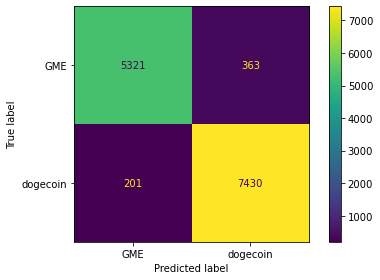

In [78]:
# plot a confusion matrix
plot_confusion_matrix(best_cvec_nb_pipe, X, y,
                      values_format = 'd',
                      display_labels = ["GME","dogecoin"])

plt.grid(False)
save_fig("confusion_matrix")
plt.show()

Overall, we can see that this simple classifier works pretty well in separating posts from Dogecoin subreddit (positive class) and GME subreddit (negative class).

Here's a quick utility function that will return the prediction for a single string:

In [79]:
def predict_subreddit(text, model = best_cvec_nb_pipe):
    target = {0: 'GME',
             1: 'dogecoin'}
    pred = model.predict([text])
    return target[pred[0]]

Let's try it out:

In [80]:
predict_subreddit(clean_text("STOP THE HEDGE FUNDS FROM DESTROYING JOBS"))

'GME'

In [81]:
predict_subreddit(clean_text("please Elon Musk, come to the studio on Saturday with a dog on your shoulders"))

'dogecoin'

We have sucessfully built a simple classifier using a simple probability model to classify posts from two different subbredits.

### Inferential Findings and Analysis
**Features of importance**

By looking at the coefficients of our production model, we can determine the words or n-grams that are of importance to r/GME and r/dogecoin.

In [82]:
# the coefficients represent P(features | Li) for each label
top_features_pos_class = best_cvec_nb_pipe.named_steps['nb'].feature_log_prob_[1]
top_features_neg_class = best_cvec_nb_pipe.named_steps['nb'].feature_log_prob_[0]
feature_names = best_cvec_nb_pipe.named_steps['cvec'].get_feature_names()

In [83]:
# dogecoin top 20 coefs
top_20_dogecoin_coefs = dict(pd.Series(np.exp(top_features_pos_class), feature_names).sort_values(ascending=False).head(20))
# gme top 20 coefs
top_20_gme_coefs = dict(pd.Series(np.exp(top_features_neg_class), feature_names).sort_values(ascending=False).head(20))

Saving figure top 20 features


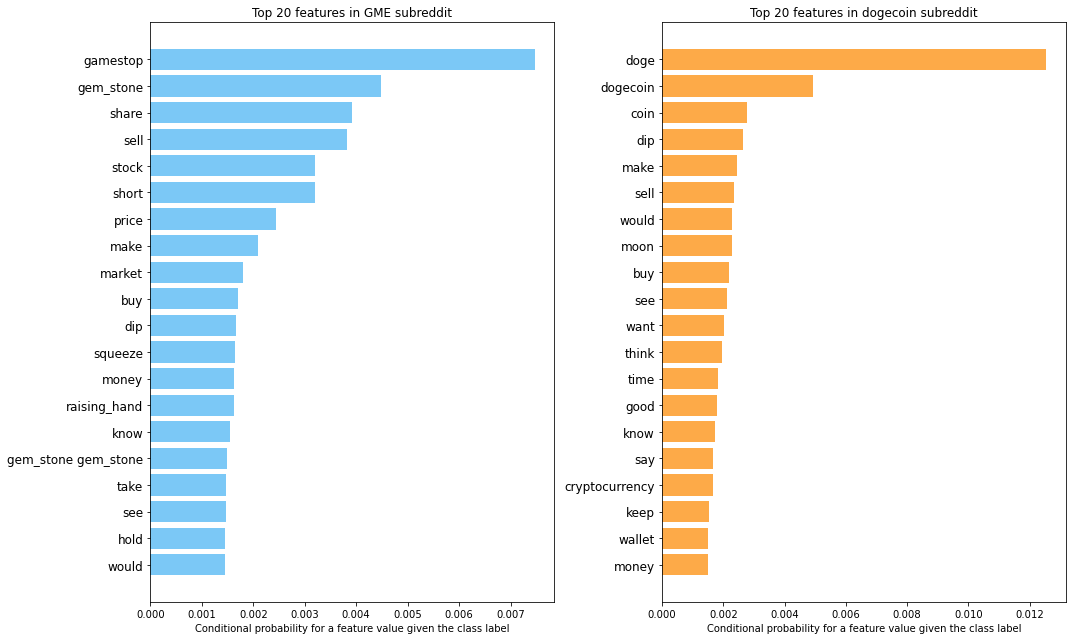

In [84]:
fig, axes = plt.subplots(1,2, figsize=(15,9));
    
# plot the first graph
plt.subplot(1,2,1)
gme_coefs = plt.barh(range(len(top_20_gme_coefs)), top_20_gme_coefs.values(),align = 'center',color='xkcd:lightblue');
    
# label axes 
plt.yticks(range(len(top_20_gme_coefs)),top_20_gme_coefs.keys(),fontsize=12);
plt.title('Top 20 features in GME subreddit')
plt.xlabel('Conditional probability for a feature value given the class label')
plt.gca().invert_yaxis()
    
# plot the second graph
plt.subplot(1,2,2)
dogecoin_coefs = plt.barh(range(len(top_20_dogecoin_coefs)), top_20_dogecoin_coefs.values(),align = 'center',color='xkcd:light orange');
    
# label axes 
plt.yticks(range(len(top_20_dogecoin_coefs)),top_20_dogecoin_coefs.keys(),fontsize=12);
plt.title('Top 20 features in dogecoin subreddit')
plt.xlabel('Conditional probability for a feature value given the class label')
plt.gca().invert_yaxis()
    
plt.subplots_adjust(wspace= 0.5)
save_fig("top 20 features")
plt.show()

We can see that the top features in GME subreddit is emoji-based and mostly terms related to gamestop & stocks. Whereas, the top features in Dogecoin subreddit are mostly terms related to dogecoin & cryptocurrency.

### Analysing posts that have been misclassified
**Example of false positive posts: Predicted as Dogecoin but it actually comes from GME subreddit.**

In [85]:
# false positives: posts that model wrongly classified as r/dogecoin
fp = predictions_df[(predictions_df['pred'] == 1) & (predictions_df['actual'] == 0)]
display(fp[12:15])

,id,full_text,cleaned_full_text,pred,actual,GME,dogecoin
252,l4qxvv,Yall just got scammed,got scamme,1,0,0.190595,0.809405
256,l4r3el,Is this really done and we got scammed or is there any chance we'll pull it back?,really do got scamme chance pull back,1,0,0.037782,0.962218
270,l4rekc,I’m not selling I’m adding more $100 calls🚀🚀🚀🚀😂🚀😂🚀😂🚀😂,sell add call face_with_tears_of_joy face_with_tears_of_joy face_with_tears_of_joy face_with_tears_of_joy,1,0,0.000045,0.999955


The example posts are considered to be generic which can be applicable to both subreddits.

**Example of false negative posts: Predicted as GME but it actually comes from Dogecoin subreddit.**

In [86]:
# false negatives: posts that model wrongly classified as r/GME
fn = predictions_df[(predictions_df['pred'] == 0) & (predictions_df['actual'] == 1)]
display(fn[12:15])

,id,full_text,cleaned_full_text,pred,actual,GME,dogecoin
7722,n55hjs,Some one help me get in Some one help me get in,one help one help,0,1,0.853323,1.466770e-01
7745,n55kk8,💎 🙌🏼 💎 🙌🏼 💎 🙌🏼 💎 🙌🏼 💎 🙌🏼 💎 🙌🏼 💎 🙌🏼 💎 🙌🏼 💎 🙌🏼 💎 🙌🏼 10. AND DON’T YOU FORGET IT,gem_stone raising_hands_mediumlight_skin_tone gem_stone raising_hands_mediumlight_skin_tone gem_stone raising_hands_mediumlight_skin_tone gem_stone raising_hands_mediumlight_skin_tone gem_stone raising_hands_mediumlight_skin_tone gem_stone raising_hands_mediumlight_skin_tone gem_stone raising_hands_mediumlight_skin_tone gem_stone raising_hands_mediumlight_skin_tone gem_stone raising_hands_medi...,0,1,1.000000,2.010079e-33
7754,n55ltc,.754 tomorrow to thursday Did some basic maths and this is my prediction.,tomorrow thursday basic math prediction,0,1,0.796485,2.035148e-01


Similarly, the example posts are considered to be generic which can be applicable to both subreddits. Moreover, there were many emojis describing diamonds hands hence it's not surprising for the model to classify such post to be from GME subreddit.

## Overall Evaluation

Beginning with a problem statement in mind, which was to use natural language processing (NLP) to classify posts from two different subreddits based on their title and text content, we have collected posts from r/GME - GameStop Stock subreddit and r/dogecoin - Dogecoin subreddit using Pushshift's API. The posts collected were then cleaned, pre-processed for exploratory data analysis (EDA) and classification modelling. Based on the insights from our EDA, we zoomed in on the characteristics (i.e the words usage/type of posts) of each subreddit and were able to learn more about the GameStop and Dogecoin mania.

Following the EDA process, we tested and evaluated three classification models - Logistic Regression, Naive Bayes & Random Forest Classifier with two different NLP vectorizers - Count Vectorizer & TF-IDF Vectorizer to select the best parameters which produce the best model performance. The Naive Bayes model using CountVectorizer was then selected as our production model. Our production model is able to classify posts from the two subreddits with an F1-Score score of 96%.

Our production model is performing relatively well given that the two subreddits are quite similar. This simple classifier will be beneficial for Reddit as a company or even the subreddit moderators to keep the contents of each subreddit relevant to the community.

### Recommendations

We would recommend the subreddit moderators of r/GME and r/dogecoin to use our model as it can correctly classify 93.61% of GME posts and 97.37% of dogecoin posts. The model hence eliminates the need for manual screening currently performed by the subreddit moderators and will free up their time to focus their expertise on more productive tasks. The subreddit moderators can also use the insights from the model to understand the overall direction of their subreddit.

Alternatively, this model can be deployed to be used by the subreddit community instead. The model can be integrated into the Reddit platform/ enabled as a browser extension, to help suggest the correct subreddit for the users to publish their post.


### Limitations

As seen from the analysis done on posts that have been misclassified, our model does have some limitations as it does not work well on generic posts. Another point to note is that this model works well for recent events. The words usage/context of the subreddits could have been different in the past few years. Hence, our model would need to be retrained using more historical data.


### Future Steps

We could look into improving the scores further by training on more data. One way of obtaining more data is to collect more posts from GameStop Subreddit and Dogecoin Subreddit by connecting to Pushshift Reddit API. Other social media sites can also be explored, eg. Twitter, where we can search for topics on 'GameStop' and 'Dogecoin'. To further minimise our false positive and false negative, we can consider trying out a more complex model leveraging semantics by using Word2Vec and BERT. This will help us to classify our posts by linguistic relationship, with a possibility of increasing our model performance.